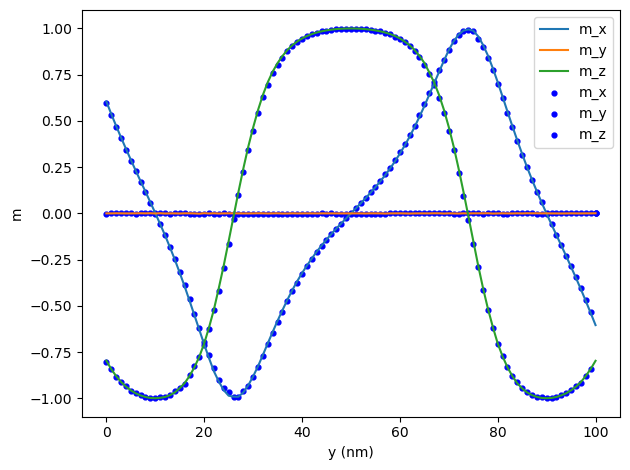

In [1]:
from pathlib import Path
import h5py
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt


# -------- helpers --------
def load_h5(fname, geom="Mesh/Grid/geometry", topo="Mesh/Grid/topology", field="Function/f/0"):
    with h5py.File(fname, "r") as h5:
        points = np.asarray(h5[geom], dtype=float)
        topo   = np.asarray(h5[topo], dtype=np.int64)
        m      = np.asarray(h5[field], dtype=float)

    if points.shape[1] != 3 or topo.shape[1] != 4 or m.shape[1] != 3:
        raise ValueError(f"Shapes inesperadas: points{points.shape}, topo{topo.shape}, m{m.shape}")
    if m.shape[0] != points.shape[0]:
        raise ValueError(f"m no coincide con #puntos: m{m.shape[0]} vs points{points.shape[0]}")
    return points, topo, m


def make_grid(points, topo, m):
    nc = topo.shape[0]
    cells = np.c_[np.full(nc, 4, np.int64), topo].ravel()
    celltypes = np.full(nc, pv.CellType.TETRA, np.uint8)
    grid = pv.UnstructuredGrid(cells, celltypes, points)
    grid.point_data["m"] = m
    return grid


def sample_along_axis(grid, axis=1, npts=100, eps_frac=1e-7):
    b = np.array(grid.bounds, float)          # [xmin,xmax,ymin,ymax,zmin,zmax]
    mins, maxs = b[::2], b[1::2]              # [xmin,ymin,zmin], [xmax,ymax,zmax]
    center = 0.5 * (mins + maxs)

    L = maxs[axis] - mins[axis]
    if L <= 0:
        raise ValueError("Error")

    p0 = center.copy(); p1 = center.copy()
    p0[axis] = mins[axis] + eps_frac * L
    p1[axis] = maxs[axis] - eps_frac * L

    sampled = pv.Line(p0, p1, resolution=npts).sample(grid)
    s = sampled["Distance"]
    mline = sampled["m"]

    mask = np.isfinite(mline).all(axis=1)
    return s[mask], mline[mask]


# -------- main --------
pattern = "relax/*.h5"
axis = 1  # line along y-axis
npts = 100

fname = "relax/Relax.h5"

points, topo, m = load_h5(fname)
grid = make_grid(points, topo, m)

s, mline = sample_along_axis(grid, axis=axis, npts=npts)
mx, my, mz = mline.T
mnorm = np.linalg.norm(mline, axis=1)

plt.plot(s, mx, label="m_x")
plt.plot(s, my, label="m_y")
plt.plot(s, mz, label="m_z")

# Compare with Finmag
data = np.loadtxt("data.txt")
plt.scatter(data[:,0], data[:,1], label="m_x",  color = 'b', s =12)
plt.scatter(data[:,0], data[:,2], label="m_y",  color = 'b', s =12)
plt.scatter(data[:,0], data[:,3], label="m_z",  color = 'b', s =12)

plt.xlabel("y (nm)")
plt.ylabel("m")
plt.legend()
plt.tight_layout()
plt.show()

